### Optimization at KPI and Summarized KPI level
##### Data Handling Assumption:
1. Works for all expressions that exist in KPI table
 - So long as the function is well defined in the table, the function works. (currently drawn logic from scorefunction()
 - In the case that it is not well-defined i.e. hvt,lvt,rt we fix the function by hand
2. We drop all records that are not actually transaction
 - This includes duplicate columns we get from drawing data from query
3. The query is a collection of sub KPIs that
 - In this case, KPI each is build up from its own sub KPIs. sub KPIs are just indicator whether each transaction fails or succeeds
4. Due to the large amount of data in a day, we put a cap on the algorithm that we put into the data.
 - The reason for this is that a sample of size 30,000 is already representative of the network. Getting a sample of size 1,000,000 over several days will slow the algorithm without yielding substantial benefits.
5. The upper bound for sampling is we never need to evaluate more than 1% of subscriber population worth of data for KPIs
6. Although the current implementation does, we do not need to leverage the current parameters in the KPI table. 
7. It makes little sense to query on aggregated time over a span of days or weeks. The computational power of up to 1% account for anything beyond that. Also getting more than one day can worsen the long tail of the distribution. If we want to span multiple period then careful aggregation is alright for reducing the number of subscriber with 0% or 100% success rate. 

#####  Computation Assumption:
1. The time it takes to evaluate is effectively unbounded. But in general, a sample size of 30,000 with 20 mutations take about 15-30 minutes.
2. When we optimize each KPI, we can set the weight parameters (max and min) to be a constant i.e. bounded by the same values.
 - This is because the only thing that impacts KPI distribution is the score itself which is only tunable through two parameters High Failure% Threshold and Low Failure% Threshold.
 - On the other hand, if we want to calculate parameters for summarized KPI (which combines "weighted" sum of KPIs) then we will also tune weight but not for KPI where weight does not matter
 - In general, we leverage the current value of weight and set them as constant while tuning KPIs
3. The algorithm also takes in booleans whether to include a score that is guaranteed to be either 1 or 5
 - By that it means if most of the given sub KPIs has 0% success rate or 100% success rate, there is not much point in tuning since there is nothing we can tune that will greatly affects the outcome distribution.
 - Therefore, the boolean, if given True, will take these untunable sub KPIs away during the computation.
4. The fitness function can change! It actually can be anything, not just the bin. The differential evolution works with any fitness function
 - As of now, the fitness function counts the percent of the KPI that falls in the specified intervals and calculate the squared difference in percentage as deviation. It then reports the sum of deviation.
5. Before any calculation begins, we drop inactive subscriber when we pull the sub KPIs. Inactive subscriber are those who, for the KPI we are tuning, have 0 fail out of 0 try which means they have never participate in that KPI.
6. The tuning is where Differential Evolution takes in the group of parameters and the fitness function to try to find the best fit parameters. It is important to realize that the BlackBox works by taking in parameters and connecting it to sub KPIs so we can find the KPIs which is put into distribution bins that result in a calculation of fitness function.
7. The fitness method is fitness which can recognize if we want to tune summarized KPI or just single KPI
8. The constructor is very much defined to reflect fitness function. If the fitness function were to change then the final fitness function has to be change. Up to the function get_data, we get sub KPIs and final fitness process the KPIs into bins. If we change fitness function then we have to make change in the constructor itself.

##### Performance and Visualization
1. The fitness function specifies an ideal condition. Currently, we want to minimize deviation from the idealized condition and the fitness function does exactly that while visualization tool put this on a graph
2. All the visualization functions which are Bar graph, CDF, Histogram, and scatter plot are listed at the bottom of the class.
3. Please note that there are two types of Bar graph. The first type is Deviation bargraph that portrays squared differences and the other type is simple Difference Bar graph

In [3]:

import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import sqlalchemy as sa
import re

# We import differential evolution algorithm here
from scipy.optimize import rosen, differential_evolution
from types import MethodType

# We set Graphs' aesthetic
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
np.random.seed(sum(map(ord, "aesthetics")))
sns.set()

In [33]:
# This is a generalized class for all KPIs

# The class defined below is the key to the whole process
class Tuning(object):
    # Initialize the class
    def __init__(self, bin_dist, bin_intervals, bounds, fixed_param, name, df_all):
        self.name = name # Name of the KPIS. For now, it has to be index of query
        self.bin_dist = bin_dist # Bin distribution specified by user
        self.bin_intervals = bin_intervals # Bin intervals specified by user
        self.bounds = bounds # Bounds of the parameters that require tuning
        self.fixed_param = fixed_param # defines parameters that are not being tuned
        self.df_all = df_all # here we input df_all_saved

        
    #####
    # Connector draws order from query/ df_all and spit out 3 columns data frame
    ######
    
    def connector(self, name_index):
        
        if isinstance(self.name[name_index], int) != True:
            df_temp = pd.DataFrame(index=self.df_all.index)
            df_temp['subscriber_key'] = copy.deepcopy(self.df_all['subscriber_key'])
            # Actually fail % This is BANDAID
            df_temp['fail'] = copy.deepcopy(self.df_all[self.name[name_index] + '_metric'])
            df_temp['total']= copy.deepcopy(self.df_all[self.name[name_index] + '_count'])
            df_temp['fail'] = copy.deepcopy(df_temp['fail'].multiply(df_temp['total']))
            return(df_temp)

    #####
    # Differential Evolution Engine
    ######
    
    # Note that drop_one and drop_five allows the function to optimize the distribution
    # without these values since sometimes the network is too effective to the extent of uni/bimodal
    
    def de_tune(self, drop_one = False, drop_five = False):
        result = differential_evolution(self.de_blackbox,\
                                        self.bounds,\
                                        [drop_one,drop_five],\
                                        strategy = 'best1bin',\
                                        maxiter = 20,\
                                        popsize = 2,\
                                        mutation = (0.5,1),\
                                        recombination = 0.5)
        return(result.x)
    
    #####
    # Black Box to feed into DE Algortihm
    ######
    # It is important to recognize that the blackbox is working at summarized KPI aka sKPI level even when feeding KPI data
    # This is because a weighted score of one KPI is just score of the KPI
    
    def de_blackbox(self, x, drop_one = False, drop_five = False):
        df_clean = self.get_data(x = x, drop_one = drop_one, drop_five = drop_five)

        # With get bin dist we find the fitness value
        
        current_bin = self.final_fitness_skpi(df_clean)
        # DEBUGGING PURPOSE
        #print(current_bin)
        return(np.sum(np.power(current_bin-self.bin_dist,2)))
    
    # Get data and get KPI data are subsidiaries of Blackbox
    def get_data(self, x, drop_one = False, drop_five = False):
        
        # we pair each subscriber_key with HT,LT,HW,LW in that order
        x_split = np.array_split(x, len(name))
        FP_split = np.array_split(self.fixed_param,len(name))

        for i in range(len(name)):
            # Now we get parameters associated with KPI_name[i]
            (HT,LT,HW,LW) = x_split[i]
            (VT,FT) = FP_split[i]

            # Connect and Get KPI level Data
            df_i = self.get_KPI_data(param = [HT,LT,HW,LW,VT,FT] , name_index=i, drop_one = drop_one, drop_five = drop_five)

            # Put this into the KQI matrix
            if i == 0:
                df = pd.DataFrame()
                df['score'+str(i+1)]=df_i['score']
                df['weight'+str(i+1)]=df_i['weight']
            else:
                df['score'+str(i+1)]=df_i['score']
                df['weight'+str(i+1)]=df_i['weight']
        # Clean the data 
        df_clean = df[(df.T != 0).any()]
        
        return(df_clean)
    # Connect and Get KPI level Data   
    # For sKPI, set cap to 4500, for KPIs level set cap to anything
    def get_KPI_data(self, param, name_index, drop_one = False, drop_five = False, cap =30000):
        
        # Connector gives out data for current KPI
        df_i = copy.deepcopy(self.connector(name_index = name_index))
        
        # rename for convenience sake
        df_i.columns = ['subscriber_key','fail','total']
        df_i = df_i[df_i.total != 0]
        # Need to optimize only up to cap or we probably will overload in terms of calculation time
        # Optional line if we want to introduce some randomness
        #df_i = df_i.sample(frac=1).set_index(self.df_all.index[0:len(df_i.index)])
        df_i = df_i.head(cap)
        # We check if drop_one and drop_five is TRUE or FALSE and drop accordingly
        df_i['ratio'] = df_i['fail'].divide(df_i['total'])
        if drop_one == True:
            df_i = df_i[df_i.ratio != 1]
        if drop_five == True:
            df_i = df_i[df_i.ratio > 0]
        # We then do calculation on df_i to get Score and Weight
        # To get score and weight for each subscriber key
        # Param has to be of length 6
        df_i['score']=df_i.apply(self.findscore, axis = 1, HT = param[0], LT = param[1])
        df_i['weight']=df_i.apply(self.findweight, axis = 1,HW=param[2],LW=param[3],VT=param[4],FT=param[5])
        # We does this to match everything in length once we get to KQI level
        df_i = df_i.sort_values(by=['score', 'weight']).set_index(self.df_all.index[0:len(df_i.index)])
        df_i = df_i.dropna().sample(frac=1).set_index(self.df_all.index[0:len(df_i.dropna().index)])
        return(df_i)
    
    # The functions below take in a columns matrix and spit out score/ weight
    def findscore(self, row, HT,LT):
        if np.divide(row['fail'],row['total']) <= LT:
            return(5)
        elif np.divide(row['fail'],row['total']) >= HT:
            return(1)
        else:
            return(5-4*np.divide(np.divide(row['fail'],row['total'])-LT,HT-LT))
        
    def findweight(self, row, HW,LW,VT,FT):
        RVolume = min(1.0,row['total']/VT)
        RFail = min(1.0,np.divide(row['fail'],row['total'])/FT)
        return(LW+(HW-LW)*RVolume*RFail)
    
    # Below are three fitness functions

    # The two main fitness functions below
    
    # Should never have to use this one again/ only for bug testing
    def final_fitness_kpi(self, df_clean):
        # Create bins
        bin_num = len(self.bin_intervals) - 1
        current_bin = np.zeros(bin_num)
        for i in range (bin_num - 1):
            current_bin[i] = df_clean[(df_clean.score1 >= self.bin_intervals[i])&(df_clean.score1 < self.bin_intervals[i+1])].count()['score1']
        current_bin[bin_num - 1] = df_clean[(df_clean.score1 >= self.bin_intervals[bin_num - 1])&(df_clean.score1 <= self.bin_intervals[bin_num])].count()['score1']
        current_bin = current_bin/sum(current_bin)
        
        return(current_bin)
    
    # Despite the label, works for both KQI and KPIs
    def final_fitness_skpi(self, df_clean):
        # Spit out weighted score then run it through KPI
        #df_clean = df_clean.fillna(0)
        # Welp
        #df_clean = copy.deepcopy(df_clean.dropna())
        df_clean['W'] = df_clean['weight1']
        df_clean['WS'] = df_clean['score1'].multiply(df_clean['weight1'])
        
        if len(df_clean.columns) != 2:
            for i in range(int((len(df_clean.columns)-3)/2)):
                df_clean['W'] = df_clean['W']+df_clean['weight'+ str(i+2)]
                df_clean['WS'] = df_clean['WS']+df_clean['score' + str(i+2)].multiply(df_clean['weight'+ str(i+2)])
        df_clean['WS'] = df_clean['WS'].divide(df_clean['W'])
        
        # Create bins
        bin_num = len(self.bin_intervals) - 1
        current_bin = np.zeros(bin_num)

        for i in range (bin_num - 1):
            current_bin[i] = df_clean[(df_clean.WS >= self.bin_intervals[i])&(df_clean.WS < self.bin_intervals[i+1])].count()['WS']
        current_bin[bin_num - 1] = df_clean[(df_clean.WS >= self.bin_intervals[bin_num - 1])&(df_clean.WS <= self.bin_intervals[bin_num])].count()['WS']
        #FOR DEBUGGING PURPOSE
        #print(current_bin)
        current_bin = current_bin/sum(current_bin)
        #for i in range (bin_num - 1):
        #    current_bin[i] = df_clean[(df_clean.score1 >= self.bin_intervals[i])&(df_clean.score1 < self.bin_intervals[i+1])].count()['WS']
        #current_bin[bin_num - 1] = df_clean[(df_clean.score1 >= self.bin_intervals[bin_num - 1])&(df_clean.score1 <= self.bin_intervals[bin_num])].count()['WS']
        #current_bin = current_bin/sum(current_bin)
        return(current_bin)
    
    #####
    # VISUALIZATION
    ######
    
    def visual_deviation(self, x, og_x, drop_one = False, drop_five = False):
        #Get data
        df_clean = self.get_data(x = x, drop_one = drop_one, drop_five = drop_five)
        df_clean_og = self.get_data(x = og_x, drop_one = drop_one, drop_five = drop_five)
        
        # Now, we compare to the ideal bin
        current_bin = self.final_fitness_skpi(df_clean)
        og_bin = self.final_fitness_skpi(df_clean_og)
        
        # Find Deviation
        current_deviation = np.power(current_bin-self.bin_dist,2)
        og_deviation = np.power(og_bin-self.bin_dist,2)

        ### Plot bar to compare deviation
        # Stack table is cool but kind of hard to understand so we will just compare deviation side by side
        fig,ax = plt.subplots()
        index = np.arange(len(current_deviation))
        bar_width = 0.35
        opacity = 0.5
        rects1 = plt.bar(index, current_deviation, bar_width, alpha =opacity,color ='b', label = 'New Deviation')
        rects2 = plt.bar(index+bar_width, og_deviation, bar_width, alpha =opacity,color ='r', label = 'Original Deviation')

        plt.ylabel('Deviation (Squared Difference)')
        plt.title('Deviation Comparison')
        plt.xticks([])
        plt.legend()
        
        ### show table for good measure
        cell_text = [[str(round(current_deviation[0],3)),str(round(current_deviation[1],3)),str(round(current_deviation[2],3))],\
                     [str(round(og_deviation[0],3)),str(round(og_deviation[1],3)),str(round(og_deviation[2],3))]]
        rows = ['New Parameters','Original Parameters']
        columns = ('['+str(self.bin_intervals[0])+'-'+str(self.bin_intervals[1])+')',\
                                      '['+str(self.bin_intervals[1])+'-'+str(self.bin_intervals[2])+')',\
                                      '['+str(self.bin_intervals[2])+'-'+str(self.bin_intervals[3])+']')
        the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          colLabels=columns)


        plt.show()
        
        ### Then print fitness score in total for wholesome comparison
        print('New deviation is      ' + str(round(self.de_blackbox(x, drop_one = drop_one, drop_five = drop_five),3)))
        print('Original deviation is ' + str(round(self.de_blackbox(og_x, drop_one = drop_one, drop_five = drop_five),3)))
        
    def visual_difference(self, x, og_x, drop_one = False, drop_five = False):
        #Get data
        df_clean = self.get_data(x = x, drop_one = drop_one, drop_five = drop_five)
        df_clean_og = self.get_data(x = og_x, drop_one = drop_one, drop_five = drop_five)
        
        # Now, we compare to the ideal bin
        current_bin = self.final_fitness_skpi(df_clean)
        og_bin = self.final_fitness_skpi(df_clean_og)
        
        # Find Difference
        current_deviation = current_bin-self.bin_dist
        og_deviation = og_bin-self.bin_dist
        
        ### Plot bar to compare deviation
        # Stack table is cool but kind of hard to understand so we will just compare difference side by side
        fig,ax = plt.subplots()
        index = np.arange(len(current_deviation))
        bar_width = 0.35
        opacity = 0.5
        rects1 = plt.bar(index, current_deviation, bar_width, alpha =opacity,color ='b', label = 'New Difference')
        rects2 = plt.bar(index+bar_width, og_deviation, bar_width, alpha =opacity,color ='r', label = 'Original Difference')
        
        plt.ylabel('Difference')
        plt.title('Comparison of Differences from Ideal Distribution')
        plt.xticks([])
        plt.legend()
        
        ### show table for good measure
        cell_text = [[str(round(current_deviation[0],3)),str(round(current_deviation[1],3)),str(round(current_deviation[2],3))],\
                     [str(round(og_deviation[0],3)),str(round(og_deviation[1],3)),str(round(og_deviation[2],3))]]
        rows = ['New Parameters','Original Parameters']
        columns = ('['+str(self.bin_intervals[0])+'-'+str(self.bin_intervals[1])+')',\
                                      '['+str(self.bin_intervals[1])+'-'+str(self.bin_intervals[2])+')',\
                                      '['+str(self.bin_intervals[2])+'-'+str(self.bin_intervals[3])+']')
        the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          colLabels=columns)


        plt.show()
        print('Deviation is a sum of squared differences')
        ### Then print fitness score in total for wholesome comparison
        print('New deviation is      ' + str(round(self.de_blackbox(x, drop_one = drop_one, drop_five = drop_five),3)))
        print('Original deviation is ' + str(round(self.de_blackbox(og_x, drop_one = drop_one, drop_five = drop_five),3))) 
        
    def visual_cdf(self, x, og_x, drop_one = False, drop_five = False):
        #Get data
        df_clean = self.get_data(x = x, drop_one = drop_one, drop_five = drop_five)
        df_clean_og = self.get_data(x = og_x, drop_one = drop_one, drop_five = drop_five)
        df_clean = self.find_WS(df_clean)
        df_clean_og = self.find_WS(df_clean_og)
        
        ### Now We stack histogram on one another to compare
        bins = np.linspace(1,5,100)
        fig, axes = plt.subplots(1, 2)
        df_clean.hist('WS', cumulative = True, density = 1,bins=100, ax=axes[0])
        df_clean_og.hist('WS',cumulative = True, density = 1, bins=100, ax=axes[1])
        axes[0].set_title('New Score CDF')
        axes[1].set_title('Old Score CDF')
        plt.show()
    def visual_hist(self, x, og_x, drop_one = False, drop_five = False):
        #Get data
        df_clean = self.get_data(x = x, drop_one = drop_one, drop_five = drop_five)
        df_clean_og = self.get_data(x = og_x, drop_one = drop_one, drop_five = drop_five)
        df_clean = self.find_WS(df_clean)
        df_clean_og = self.find_WS(df_clean_og)
        
        ### Now We stack histogram on one another to compare
        bins = np.linspace(1,5,100)
        fig, axes = plt.subplots(1, 2)
        df_clean.hist('WS', bins=100, ax=axes[0])
        df_clean_og.hist('WS', bins=100, ax=axes[1])
        axes[0].set_title('New Score Histogram')
        axes[1].set_title('Old Score Histogram')
        plt.show()
    def find_WS(self, df_clean):
        # Spit out weighted score then run it through KPI
        df_clean = df_clean.fillna(0)
        df_clean['W'] = df_clean['weight1']
        df_clean['WS'] = df_clean['score1'].multiply(df_clean['weight1'])
        if len(df_clean.columns) != 2:
            for i in range(int((len(df_clean.columns)-3)/2)):
                df_clean['W'] = df_clean['W']+df_clean['weight'+ str(i+2)]
                df_clean['WS'] = df_clean['WS']+df_clean['score' + str(i+2)].multiply(df_clean['weight'+ str(i+2)])
        df_clean['WS'] = df_clean['WS'].divide(df_clean['W'])

        return(df_clean)
    def visual_scatter(self, x, og_x, drop_one = False, drop_five = False):
        #Get data
        df_clean = self.get_data(x = x, drop_one = drop_one, drop_five = drop_five)
        df_clean_og = self.get_data(x = og_x, drop_one = drop_one, drop_five = drop_five)
        for i in range(int(len(df_clean.columns)/2)):
            ### Now We stack scatter plot on one another to compare
            fig, axes = plt.subplots(1, 2)
            df_clean.plot.scatter('score'+str(i+1),'weight'+str(i+1), ax=axes[0], alpha = 0.2)
            df_clean_og.plot.scatter('score'+str(i+1),'weight'+str(i+1), ax=axes[1], alpha = 0.2)
            axes[0].set_title('New Scatter Plot: Score vs Weight')
            axes[1].set_title('Old Scatter Plot: Score vs Weight')
            plt.show()

In [48]:
# Load the csv
df_all_saved =pd.read_csv("example_data_table.csv")

In [36]:
# KPI 1
name = ['kpi1']

# Assume ideal bin
bin_dist = [0.3,0.2,0.5]
bin_intervals = [1,2,4,5]

# Set tuning bounds (we only tune two parameters here)
bounds = [(100, 0), (30, 0), (0, 0), (0, 0)]
fixed_param = [0,0]


test = Tuning(bin_dist, bin_intervals, bounds, fixed_param, name,df_all_saved)

# Default parameter for comparison
default_x = [50,0,0,0]

In [37]:
# Tune the algorithms
tuned_x = test.de_tune()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib64/python3.6/site-packages/scipy/optimize/_differentialevolution.py:750: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


In [55]:
# Now, we get the parameters to compare to the default
# For instance
tuned_x = [20.13427937,  3.00870198, 50.        , 10.        ]

array([20.13427937,  3.00870198, 50.        , 10.        ])

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in double_scalars


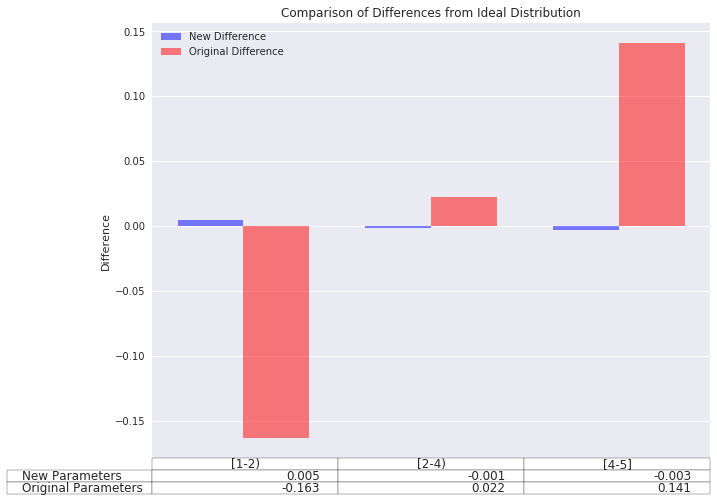

Deviation is a sum of squared differences
New deviation is      0.0
Original deviation is 0.047


In [56]:
# Visualization
test.visual_difference(tuned_x,og_x)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in double_scalars
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in double_scalars


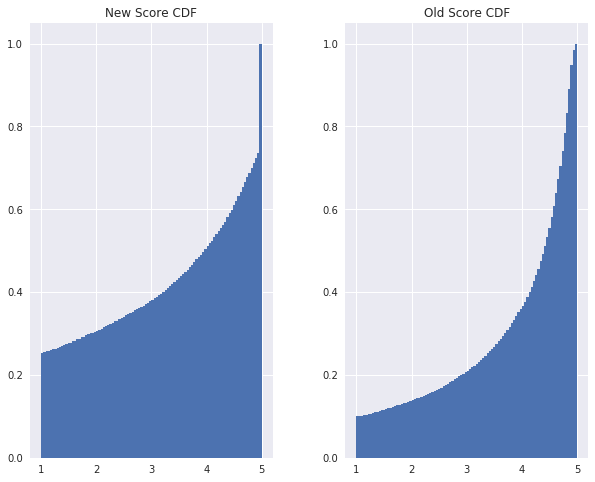

In [57]:
test.visual_cdf(tuned_x,og_x)